In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split


In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

In [ ]:
train_data_dir  = '/content/drive/MyDrive/Final year Project/train'

classes = os.listdir(data_dir)
print(classes)

In [ ]:
len(classes)

10

In [ ]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((120, 120)), transforms.ToTensor()])

train_ds = ImageFolder(train_data_dir, transform = transformations)

In [ ]:
def show_img(img, label):
    print('Label: ', train_ds.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  pet (5)


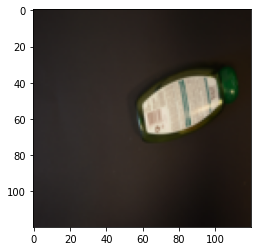

In [ ]:
img, label = train_ds[2222]
show_img(img, label)

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);

In [ ]:
len(train_ds)

4407

In [ ]:
average  = torch.Tensor([0,0,0])
standard_dev = torch.Tensor([0,0,0])

In [ ]:
count =0

In [ ]:
for image in train_ds:
  average += image[0].mean([1,2])
  standard_dev += image[0].std([1,2])
  count += 1
  print(count)

In [ ]:
stats = ((average / len(train_ds)).tolist(), (standard_dev / len(train_ds)).tolist())
stats

([0.41141992807388306, 0.380613774061203, 0.33901548385620117],
 [0.15257222950458527, 0.1494765728712082, 0.1491573601961136])

In [6]:
stats = ([0.41141992807388306, 0.380613774061203, 0.33901548385620117],
 [0.15257222950458527, 0.1494765728712082, 0.1491573601961136])

In [7]:
train_tfms = transforms.Compose([transforms.RandomCrop(32, padding=4,padding_mode='reflect'),
                         transforms.Resize((120, 120)), 
                         transforms.RandomHorizontalFlip(), 
                         transforms.ToTensor(), 
                         transforms.Normalize(*stats,inplace=True)
                        ])
valid_tfms = transforms.Compose([transforms.Resize((120, 120)), transforms.ToTensor(), transforms.Normalize(*stats)
                        ])
test_tfms = transforms.Compose([transforms.Resize((120, 120)), transforms.ToTensor(), transforms.Normalize(*stats)
                        ])
           

In [8]:
data_dir = "/content/drive/MyDrive/Final year Project"

In [9]:
train_ds = ImageFolder(data_dir+'/train', train_tfms)
val_ds = ImageFolder(data_dir+'/val', valid_tfms)
test_ds = ImageFolder(data_dir+'/test', test_tfms)

In [32]:
batch_size = 32

In [33]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [12]:
import torch.nn as nn
import torch.nn.functional as F

In [13]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 60 x 60

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 30 x 30

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 15 x 15

            nn.Flatten(), 
            nn.Linear(256*15*15, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = CnnModel()
model

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=57600, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([256, 3, 120, 120])
out.shape: torch.Size([256, 10])
out[0]: tensor([ 0.0064, -0.0307,  0.0444,  0.0004, -0.0441,  0.0259, -0.0437, -0.0247,
        -0.0165,  0.0147], grad_fn=<SelectBackward0>)


In [ ]:
class PaperModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, padding=1),
            nn.MaxPool2d(2, 2), # output: 64 x 60 x 60

            nn.ReLU(),
            nn.Conv2d(64,64, kernel_size = 5, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(2,2), # output 64 x 30 x 30

            nn.Conv2d(64,64, kernel_size = 5, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(2,2), # output 64x15x15
    
            nn.Linear(256*15*15, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(CnnModel(), device)

In [ ]:
evaluate(model, val_dl)

{'val_loss': 2.3116016387939453, 'val_acc': 0.0703125}

In [ ]:
num_epochs = 12
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 2.0880, val_loss: 1.8064, val_acc: 0.3059
Epoch [1], train_loss: 1.7636, val_loss: 1.5600, val_acc: 0.4212
Epoch [2], train_loss: 1.6612, val_loss: 1.4623, val_acc: 0.4202
Epoch [3], train_loss: 1.6463, val_loss: 1.5630, val_acc: 0.3645
Epoch [4], train_loss: 1.5991, val_loss: 1.5169, val_acc: 0.4006
Epoch [5], train_loss: 1.5794, val_loss: 1.6581, val_acc: 0.3967
Epoch [6], train_loss: 1.5479, val_loss: 1.5588, val_acc: 0.3889
Epoch [7], train_loss: 1.5337, val_loss: 1.5834, val_acc: 0.4244
Epoch [8], train_loss: 1.5424, val_loss: 1.5379, val_acc: 0.3996
Epoch [9], train_loss: 1.5680, val_loss: 1.5417, val_acc: 0.4460


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
plot_losses(history)

In [ ]:
model_path = "/content/drive/MyDrive/Final year Project/model_v4_30_nov_120p.pt"

In [ ]:
torch.save(model.state_dict(), model_path)

In [ ]:
torch.save(model, "/content/drive/MyDrive/Final year Project/full_model_v4_30_nov_120p.pt")

# Resnet implementation


In [14]:
import torchvision.models as models

In [17]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(train_ds.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))



In [18]:
model = ResNet()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [20]:
device = get_default_device()
device

device(type='cuda')

In [34]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [35]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [36]:
model = to_device(ResNet(), device)

In [37]:
import torch.nn.functional as F

In [38]:
evaluate(model, val_dl)

{'val_loss': 2.2912607192993164, 'val_acc': 0.10130494087934494}

In [39]:
num_epochs = 12
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.9560, val_loss: 2.1412, val_acc: 0.2656
Epoch [1], train_loss: 1.8564, val_loss: 2.2374, val_acc: 0.1731
Epoch [2], train_loss: 1.8401, val_loss: 2.2998, val_acc: 0.1346
Epoch [3], train_loss: 1.8280, val_loss: 2.1744, val_acc: 0.2308
Epoch [4], train_loss: 1.8276, val_loss: 2.3621, val_acc: 0.1154
Epoch [5], train_loss: 1.8194, val_loss: 2.2354, val_acc: 0.1394
Epoch [6], train_loss: 1.8144, val_loss: 2.0672, val_acc: 0.2861
Epoch [7], train_loss: 1.8170, val_loss: 2.0823, val_acc: 0.3185
Epoch [8], train_loss: 1.8159, val_loss: 2.2660, val_acc: 0.1707
Epoch [9], train_loss: 1.8143, val_loss: 2.3303, val_acc: 0.1142
Epoch [10], train_loss: 1.8088, val_loss: 2.3573, val_acc: 0.1274
Epoch [11], train_loss: 1.8103, val_loss: 2.3344, val_acc: 0.1791


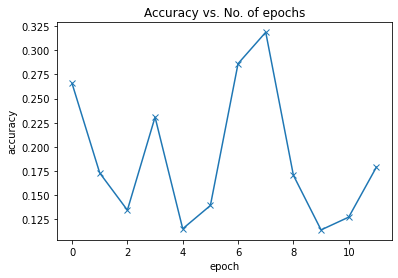

In [40]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

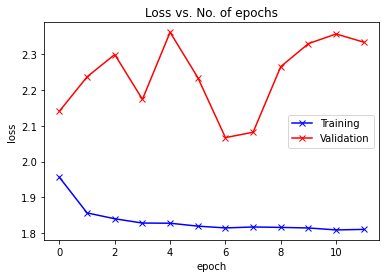

In [41]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [42]:
model_path = "/content/drive/MyDrive/Final year Project/model_state_resnet50_v5_1_dec.pt"

In [43]:
torch.save(model.state_dict(), model_path)

In [44]:
torch.save(model, "/content/drive/MyDrive/Final year Project/full_model_resnet50_v5_1_dec.pt")